# A simple CNN with Pytorch

We will build a classifier on CIFAR10 to predict the class of each image, using PyTorch along the way. 

This is basically following along with [this tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) except I add rough notes to explain things as I go. There were a lot of things I didn't find straightforward, so hopefully this piece can help someone else out there. 

Start off with initialisations

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
%matplotlib inline 
path_data = './data/'

## Getting the data 

Pytorch provides a package called `torchvision` that is a useful utility for getting common datasets. Using this package we can download train and test sets CIFAR10 easily and save it to a folder. The training set is about 270MB. If you've already downloaded it once, you don't have to redownload it. 

In [2]:
train = torchvision.datasets.CIFAR10(root=path_data, train=True, download=True) 
test = torchvision.datasets.CIFAR10(root=path_data, train=False, download=True) 

Files already downloaded and verified
Files already downloaded and verified


Let's look at `train`. What we get from this is a class called `CIFAR10`. 

In [3]:
type(train)

torchvision.datasets.cifar.CIFAR10

Let's inspect this object. There's a few useful things you can do with this class: 

* **`train.classes`:** view the output classes as strings 
* **`train.targets`:** numericalised output classes (0-9)
* **`train.class_to_idx`:** mapping between `train.classes` and `train.targets`
* **`train.data`:** has the raw data as a PIL Image, held in `numpy.ndarray` format in the range [0,255], in the order (H x W x C). This has shape `(50000, 32, 32, 3)`.

As always `train.__dict__` lets you see everything at once. 

Now its time to transform the data. Use `torchvision.transforms` for this. Some basic transforms: 

* **`transforms.ToTensor()`**:  convers PIL/Numpy to Tensor format. It converts a PIL Image or numpy.ndarray with range [0,255] and shape (H x W x C) to a torch.FloatTensor of shape (C x H x W) and range [0.0, 1.0]. So this operation also rescales your data. It's not a simple "ndarray --> tensor" operation. 

* **`transforms.Normalize()`**:  normalises each channel of the input Tensor. The formula is this: `input[channel] = (input[channel] - mean[channel]) / std[channel]`. You have to pass in two parameters: a sequence of means for each channel, and a sequence of standard deviations for each channel. In practice you see this called as `transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))` (for the CIFAR10 example) rather than `transforms.Normalize((127.5,127.5,127.5), (some_std_here))` because it is put after `transforms.ToTensor()` and that rescales to 0-1. 

* **`transforms.Compose()`**: the function that lets you chain together different transforms. 

In [4]:
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

Most examples specify a transform when calling a dataset (like `torchvision.datasets.CIFAR10`) using the `transform` parameter. But I think you can also just add it to the `transform` and `transforms` attribute of the `train` or `test` object. The transform doesn't get called at this point anyway: you need a `DataLoader` to execute it. 
The difference with `transforms` is you need to run it through the `torchvision.datasets.vision.StandardTransform` class to get the exact same behaviour. So do this:

In [5]:
train.transform = cifar_transform
test.transform = cifar_transform
train.transforms = torchvision.datasets.vision.StandardTransform(cifar_transform)
test.transforms = torchvision.datasets.vision.StandardTransform(cifar_transform)


and it should be fine. Now use `train.transform` or `train.transforms` to see if it worked:

In [6]:
print(train.transform)
print('\n######\n')
print(train.transforms)

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

######

StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


Note `train.data` remains unscaled after the transform. Transforms are only applied with the `DataLoader`. 

### Datasets and DataLoaders

There are two types of `Dataset` in Pytorch. The first type is called a *map-style dataset* and is a class that implements `__len__()` and `__getitem__()`. You can access individual points of one of these datasets with square brackets (e.g. `data[3]`) and it's the type of dataset for most common needs. Then there's the *iterable-style dataset* that implements `__iter__()` and is used for streaming-type things. The [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class is a map-style dataset and the [IterableDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset) class is an iterable-style dataset. In this case CIFAR10 is a map-style dataset. 

The `DataLoader` class combines with the `Dataset` class and helps you iterate over a dataset. You can specify how many data points to take in a batch, to shuffle them or not, implement sampling strategies, use multiprocessing for loading data, and so on. Without using a `DataLoader` you'd have a lot more overhead to get things working: implement your own for-loops with indicies, shuffle batches yourself and so on. 

We make a loader for both our train and test set. The tutorial sets `shuffle=False` for the test set; there's no need to shuffle the data when you are just evaluating it. 

In [7]:
trainloader = torch.utils.data.DataLoader(train, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(train, batch_size=4,
                                          shuffle=False, num_workers=2)

You can get some data by converting `trainloader` to an iterator and then calling `next` on it. This gives us a list of length 2: it has both the training data and the labels, or in common maths terms, $(X, y)$.

Let's look at a batch in raw form. 

In [8]:
train_iter = iter(trainloader)
images, labels = train_iter.next()
print(images[0])

tensor([[[ 0.4902,  0.6157,  0.5686,  ...,  0.8824,  0.8902,  0.7333],
         [ 0.7020,  0.4980,  0.5216,  ...,  0.7020,  0.6078,  0.1765],
         [ 0.6392,  0.2549,  0.3098,  ...,  0.7647,  0.6000,  0.0275],
         ...,
         [-0.1529, -0.4980, -0.3490,  ...,  0.0902,  0.0196, -0.2627],
         [ 0.3255, -0.1608, -0.0745,  ..., -0.0196, -0.0745, -0.3176],
         [ 0.1059, -0.3725, -0.3333,  ..., -0.3804, -0.4039, -0.4824]],

        [[ 0.7804,  0.8039,  0.7804,  ...,  0.9451,  0.9529,  0.7961],
         [ 0.8196,  0.5216,  0.5686,  ...,  0.7333,  0.6549,  0.2706],
         [ 0.7569,  0.2784,  0.3647,  ...,  0.7804,  0.6314,  0.1216],
         ...,
         [-0.0588, -0.4196, -0.3176,  ..., -0.0275, -0.0824, -0.3490],
         [ 0.2706, -0.2078, -0.1686,  ..., -0.1373, -0.1843, -0.4039],
         [-0.0588, -0.4902, -0.4667,  ..., -0.4902, -0.5059, -0.5608]],

        [[ 0.9529,  0.9137,  0.9294,  ...,  0.9608,  0.9686,  0.8275],
         [ 0.8745,  0.5608,  0.6235,  ...,  0

 The batch has shape `torch.Size([4, 3, 32, 32])`, since we set the batch size to 4. It's also been rescaled to be between -1 and 1, or in other words: all the transforms in `cifar_transform` have been executed now. 

### Plotting images 

It'd be useful to us to try and plot what's in `images` as actual images. So let's do that. 

The `images` array is a Tensor and is arranged in the order (B x C x H x W), where B is batch size, C is channels, H height and W width. If we want to use image plotting methods from `matplotlib` like `imshow`, we need each image to look like (H x W x C). Another problem is that `imshow` needs values between 0 and 1, and currently our image values are between -1 and 1. 

Useful to this is the function `torchvision.utils.make_grid()`. What this does is take a bunch of separate images and squish them together into a 'film-strip' style image with axes in order of (C x H x W) with some amount of `padding` between each image. So we'll do this to merge our `images`, reshape the axes with `np.transpose()` into an `imshow` compatible format, and then we can plot them. 

airplane truck automobile truck


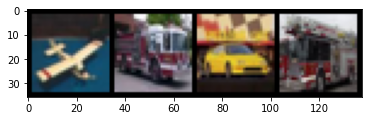

In [9]:
def plot_images(images, labels): 
    # normalise=True below shifts [-1,1] to [0,1]
    img_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
    np_img = img_grid.numpy().transpose(1,2,0)  
    plt.imshow(np_img)
    
d_class2idx = train.class_to_idx
d_idx2class = dict(zip(d_class2idx.values(),d_class2idx.keys()))

images, labels = train_iter.next()
plot_images(images,labels)
print(' '.join('%5s' % d_idx2class[int(labels[j])]for j in range(len(images))))

## Making the CNN 

In [10]:
import torch.nn as nn 
import torch.nn.functional as F 

We're going to define a class `Net` that has the CNN. This class will inherit from `nn.Module` and have two methods: an `__init__()` method and a `forward()` method. Here's the architecture (except ours is on CIFAR, not MNIST):

![](data/convnet_architecture.jpg)

### Neural network components 

It looks like all layers run only for a batch of samples and not for a single point. The input to a `nn.Conv2d` layer for example will be something of shape (nSamples x nChannels x Height x Width), or (S x C x H x W).

If you want to put a single sample through, you can use `input.unsqueeze(0)` to add a fake batch dimension to it so that it will work properly. 

#### Convolutional layers

The first type of layer we have is a 2D convolutional layer, implemented using `nn.Conv2d()`. This has three compulsory parameters: 

* `in_channels`: basically the number of channels in your input data. For CIFAR we have 3 channels (RGB), for a dataset like MNIST we would only have one. 
* `out_channels`: the number of convolutional filters you'd like to have in this layer. The network will learn the weights for all of these. 
* `kernel_size`: the size of the square filter. Set to 3 to use 3x3 conv filters, 2 to use 2x2 conv filters etc. 

There are also a bunch of other parameters you can set: `stride`, `padding`, `dilation` and so forth. [This link](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) has a good description of these parameters and how they affect the results. 

These are called `nn.MaxPool2d()`. The compulsory parameter is `kernel_size` and it sets the size of the square window to which the maxpool operator is called. Like before you can set `strides` and other parameters. 

#### Linear layers

A simple linear layer of the form $y = XW + b$. 

Parameters: `in_features` (neurons coming into the layer), `out_features` (neurons going out of the layer) and `bias`, which you should set to True almost always.  

#### Activations

We will use ReLu activations in the network. We can find that in `F.relu` and it is simple to apply. We'll use the `forward` method to take layers we define in `__init__` and stitch them together with `F.relu` as the activation function. 

#### Reshaping 

If `x` is a Tensor, we use `x.view` to reshape it. For example, if `x` is given by a 16x1 tensor. `x.view(4,4)` reshapes it to a 4x4 tensor. You can write `-1` to infer the dimension on that axis, based on the number of elements in `x` and the shape of the other axes. For example,  `x.view(2,-1)` returns a Tensor of shape 2x8. Only one axis can be inferred. 

The `view` function doesn't create a new object. The object returned by `view` shares data with the original object, so if you change one, the other changes. This contrasts with `np.reshape`, which returns a new object. 

$$\frac{W−K+2P}{S} +1$$

- W is the input volume
- K is the kernel size
- P is the amount of padding
- S is the stride size

64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

In [26]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1) 
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=1) 
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3,padding=1) 
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,padding=1) 
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3,padding=1) 
        self.conv7 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3,padding=1) 
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3,padding=1) 
        
        # 5*5 comes from the dimension of the last convnet layer
        self.fc1 = nn.Linear(512,512) 
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512, 10)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))
        x = F.relu(self.conv7(x))
        x = self.pool(F.relu(self.conv8(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # no activation on final layer 
        return x

net = Net()

### Loss function and optimisation 

We will use a cross entropy loss, found in the function `nn.CrossEntropyLoss()`. This function expects raw logits as the final layer of the neural network, which is why we didn't have a softmax final layer. The function also has a `weights` parameter which would be useful if we had some unbalanced classes, because it could oversample the rare class. 

Optimisation is done with stochastic gradient descent, or `optim.SGD`. The first argument is the parameters of the neural network: i.e. you are giving the optimiser something to optimise. Second argument is the learning rate, and third argument is an option to set a momentum parameter and hence use momentum in the optimisation. Other options include dampening for momentum, l2 weight decay and an option for Nesterov momentum. 

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Note that `nn.CrossEntropyLoss()` returns a function, that we've called `criterion`, so when you see `criterion` later on remember it's actually a function.  

### Training 

Let's go through how to train the network. 

A reminder: we'd defined `trainloader` like this: 
```
trainloader = torch.utils.data.DataLoader(train, batch_size=4, 
                                          shuffle=True, num_workers=2)
```

If we iterate through `trainloader` we get tuples with `(data, labels)`, so we'll have to unpack it. The variable `data` refers to the image data and it'll come in batches of 4 at each iteration, as a Tensor of size `(4, 3, 32, 32)`. `labels` will be a 1d Tensor. 

Next we zero the gradient with `optimizer.zero_grad()`. Gradients aren't reset to zero after a backprop step, so if we don't do this, they'll accumulate and won't be correct. 

Then comes the forward pass. We created an instance of our `Net` module earlier, and called it `net`. We can put an image through the network directly with `net(inputs)`, which is the same as the forward pass. 

Loss is easy: just put `criterion(outputs, labels)`, and you'll get a tensor back. Backpropagate with `loss.backward()`, and rely on the autograd functionality of Pytorch to get gradients for your weights with respect to the loss (no analytical calculations of derivatives required!)

Update weights with `optimizer.step()`. This uses the learning rate and the algorithm that you seeded `optim.SGD` with and updates the parameters of the network (that you also gave to `optim.SGD`)

Finally, we'll want to keep track of the average loss. This will let us see if our network is learning quickly enough. We'll print out diagnostics every so often. 

In [28]:
# variable to save the value of the loss
running_loss = 0 

# print when the counter is divisible by this value
printfreq = 1000

# training loop
num_epochs = 2
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)  # forward pass 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % printfreq == printfreq-1:  
            print("Epoch: {}, Training Loss: {}".format(epoch, running_loss / printfreq))
            running_loss = 0 

Epoch: 0, Training Loss: 2.303196001291275
Epoch: 0, Training Loss: 2.303591883659363
Epoch: 0, Training Loss: 2.303332814693451
Epoch: 0, Training Loss: 2.3032657248973845
Epoch: 0, Training Loss: 2.303886539697647
Epoch: 0, Training Loss: 2.303656171798706
Epoch: 0, Training Loss: 2.303501182556152
Epoch: 0, Training Loss: 2.303439744234085
Epoch: 0, Training Loss: 2.303251069545746
Epoch: 0, Training Loss: 2.30255917096138
Epoch: 0, Training Loss: 2.3036081674098967
Epoch: 0, Training Loss: 2.3034356265068054
Epoch: 1, Training Loss: 3.4550213763713837
Epoch: 1, Training Loss: 2.303252022743225
Epoch: 1, Training Loss: 2.3039919493198395
Epoch: 1, Training Loss: 2.303289253234863
Epoch: 1, Training Loss: 2.3029954946041107
Epoch: 1, Training Loss: 2.3038032412528993
Epoch: 1, Training Loss: 2.30340350651741
Epoch: 1, Training Loss: 2.3037475438117982
Epoch: 1, Training Loss: 2.3033275756835936
Epoch: 1, Training Loss: 2.3031694638729094
Epoch: 1, Training Loss: 2.3027311325073243
Ep

#### Saving, loading, and `state_dict` 

It is good to save and load models. Models can take a long time to train, so saving them after they are done is good to avoid retraining them. You'll also need a way to reload them. 

When saving a model, we want to save the `state_dict` of the network (`net.state_dict()`, which holds weights for all the layers. This doesn't save any of the optimiser information, so if we want to save that, we can also save `optimiser.state_dict()` too. 

Let's have a look in the `state_dict` of our `net` that we trained:

In [29]:
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

conv1.weight 	 torch.Size([64, 3, 3, 3])
conv1.bias 	 torch.Size([64])
conv2.weight 	 torch.Size([128, 64, 3, 3])
conv2.bias 	 torch.Size([128])
conv3.weight 	 torch.Size([256, 128, 3, 3])
conv3.bias 	 torch.Size([256])
conv4.weight 	 torch.Size([256, 256, 3, 3])
conv4.bias 	 torch.Size([256])
conv5.weight 	 torch.Size([512, 256, 3, 3])
conv5.bias 	 torch.Size([512])
conv6.weight 	 torch.Size([512, 512, 3, 3])
conv6.bias 	 torch.Size([512])
conv7.weight 	 torch.Size([512, 512, 3, 3])
conv7.bias 	 torch.Size([512])
conv8.weight 	 torch.Size([512, 512, 3, 3])
conv8.bias 	 torch.Size([512])
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([512, 512])
fc2.bias 	 torch.Size([512])
fc3.weight 	 torch.Size([10, 512])
fc3.bias 	 torch.Size([10])


We can see the bias and weights are saved, each in the correct shape of the layer. 

Let's look at the `state_dict` of the optimiser object too: 

In [30]:
print(optimizer.state_dict().keys())
print(optimizer.state_dict()['param_groups'])

dict_keys(['state', 'param_groups'])
[{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [140308757292608, 140308757292768, 140308757292688, 140308757292848, 140308757284976, 140308757292928, 140308757293008, 140308757293088, 140308757293168, 140308757293248, 140308757293328, 140308757293408, 140308757293488, 140308757293568, 140308757293648, 140308757293728, 140308757293808, 140308757293888, 140308757293968, 140308757294048, 140308757294128, 140308757294208]}]


There's more, but it's big, so I won't print it. 

Saving and loading is done with `torch.save` , `torch.load`, and `net.load_state_dict`. Saving an object will pickle it. It seems to be a PyTorch convention to save the weights with a `.pt` or a `.pth` file extension. 

In [17]:
fname = './models/CIFAR10_cnn.pth'
torch.save(net.state_dict(), fname)
loaded_dict = torch.load(fname)
net.load_state_dict(loaded_dict)

<All keys matched successfully>

Some layers like Dropout or Batchnorm won't work properly if you don't call `net.eval()` after loading. 

In [31]:
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

There is much more to saving and loading than this. Check out [this guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for more information. Some examples: transfer learning, model checkpointing, transferring from CPU to GPU and vice versa. 

### Model testing 

It's time to see how our trained `net` does on the test set. Will it have learned anything?

As a sanity check, let's first take some images from our test set and plot them with their ground-truth labels:

In [19]:
# Reload net if needed
fname = './models/CIFAR10_cnn.pth'
loaded_dict = torch.load(fname)
net.load_state_dict(loaded_dict)

<All keys matched successfully>

```python
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
```

 frog truck truck  deer


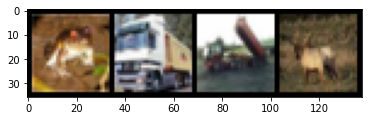

In [35]:
dataiter = iter(testloader)
images, labels = dataiter.next()
plot_images(images,labels)
print(' '.join('%5s' % d_idx2class[int(labels[j])]for j in range(len(images))))

Looks good. Now let's run the images through our net and see what we get. 

In [33]:
# LOGIT

In [36]:
outputs = net(images)
print(outputs)

tensor([[-2.4118, -2.2808,  1.8143,  1.7406,  1.7698,  1.2388,  3.5819,  0.2656,
         -2.5805, -2.5137],
        [ 2.5863,  0.5393, -0.3319, -1.7197, -2.0875, -1.1261, -4.7306,  1.5799,
          0.4269,  4.3569],
        [ 1.7458,  0.6160, -0.8402, -0.7255, -2.4749, -1.0881, -3.2697,  0.4478,
          2.3743,  4.1688],
        [-0.6781, -2.7646,  2.6483, -0.0929,  5.3070,  0.4124,  2.9908, -1.7240,
         -2.3775, -2.9401]], grad_fn=<AddmmBackward>)


These are logits for each of the ten classes. Since the highest logit will be the predicted class, we can generate labels easily from the logits. 

airplane airplane airplane airplane


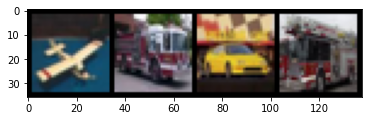

In [31]:
preds = outputs.argmax(dim=1)
plot_images(images,preds)
print(' '.join('%5s' % d_idx2class[int(preds[j])]for j in range(len(images))))

It's got some right, not all. For a better evaluation of performance, we'll have to look at performance across the entire test set. 

Most of the code follows similar patterns to the training loop above. I'll comment on the things I find interesting. 

A useful function is `torch.max()`. This returns a namedtuple with the standard max values along an axis, but somewhat usefully also the argmax values along that axis, too. This is good for us because we don't really care about the max value, but more its argmax, since that corresponds to the label. 

We can do element-wise comparison with `==` on PyTorch tensors (and Numpy arrays too). We see this in the line using `predicted == labels` below, which will return a vector filled with True/False values. If `predicted` and `labels` were lists, by comparison, we'd just get a single True value if all the elements were the same, or False if any were different.
`

Note the code is inside the `torch.no_grad()` context manager, which turns off gradient tracking for the variables. It's claimed that this reduces memory usage, and increases computation speed. I wasn't sure, so I did a rudimentary speed test. I didn't track the memory usage, but there is definitely a speed benefit, so it's probably worth the effort to do.   
Results:  
* with `no_grad()`: 50.8 s
* without `no_grad()`: 55.6s  

In [32]:
total = 0  # keeps track of how many images we have processed 
correct = 0  # keeps track of how many correct images our net predicts
with torch.no_grad():
    for i, data in enumerate(testloader): 
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size()[0]
        correct += (predicted == labels).sum().item()
    
print("Accuracy: ", correct/total)

Accuracy:  0.1


We are tracking at about 56% accuracy. 

#### Prediction analysis

We're going to want to know how our model does on different classes. It's unlikely its predictions for every class will be similarly accurate. 

In [33]:
class_correct = list(0 for i in range(10))  # Holds how many correct images for the class
class_total = list(0 for i in range(10))  # Holds total images for the class 

with torch.no_grad(): 
    for i, data in enumerate(testloader): 
        images, labels = data 
        outputs = net(images) 
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        for j in range(4): 
            label = labels[j]
            class_correct[label] += c[j].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        d_idx2class[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 100 %
Accuracy of automobile :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


You can see significant differences in the accuracy of different classes. For example, our network is bad at predicting birds, but better at predicting horses. 

In [34]:
from sam import SAM

In [41]:
# From SAM paper: https://arxiv.org/abs/2010.01412
base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer = SAM(net.parameters(), base_optimizer, lr=0.1, momentum=0.9)


# variable to save the value of the loss
running_loss = 0 

# print when the counter is divisible by this value
printfreq = 1000

# training loop
num_epochs = 2
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        
        # first forward-backward pass 
        outputs = net(inputs)  # forward pass 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.first_step(zero_grad=True)
        
        # second forward-backward pass
        outputs = net(inputs)  # forward pass 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.second_step(zero_grad=True)
        
        running_loss += loss.item()
        if i % printfreq == printfreq-1:  
            print("Epoch: {}, Training Loss: {}".format(epoch, running_loss / printfreq))
            running_loss = 0 

Epoch: 0, Training Loss: 3662594837837031.0
Epoch: 0, Training Loss: 2.3819046630859373
Epoch: 0, Training Loss: 2.3874630360603333
Epoch: 0, Training Loss: 2.381780567288399
Epoch: 0, Training Loss: 2.3878946294784544
Epoch: 0, Training Loss: 2.383088944554329
Epoch: 0, Training Loss: 2.3814951595067977
Epoch: 0, Training Loss: 2.3802467943429946
Epoch: 0, Training Loss: 2.380187257766724
Epoch: 0, Training Loss: 2.3824819115400313
Epoch: 0, Training Loss: 2.3819320375919344
Epoch: 0, Training Loss: 2.3852213350534437
Epoch: 1, Training Loss: 3.5762417969703675
Epoch: 1, Training Loss: 2.3844455664157866
Epoch: 1, Training Loss: 2.3854297120571135
Epoch: 1, Training Loss: 2.3844191105365753
Epoch: 1, Training Loss: 2.387171325325966
Epoch: 1, Training Loss: 2.3875990554094315
Epoch: 1, Training Loss: 2.3781816284656525
Epoch: 1, Training Loss: 2.38891989839077
Epoch: 1, Training Loss: 2.3808647471666338
Epoch: 1, Training Loss: 2.3797028894424437
Epoch: 1, Training Loss: 2.37971593308